In [1]:
import mlflow

mlflow.set_tracking_uri("http://aiserver.tzp.haw-landshut.de:5050")
mlflow.set_experiment("RandomForestClassifier_paperd")

logged_model = 'runs:/b02828f973a2431e84889eadaccf8e02/randomForest'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# 1. Parse files

In [2]:
import os
import json
import re
import numpy as np

def parse_acceleration_data(folder_path, filenameContainsWord=None):
    """
    Parses acceleration data from JSON files in a folder.

    Args:
        folder_path (str): Path to the folder containing the JSON files.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray]: A tuple containing the acceleration data and the labels.

    Raises:
        ValueError: If the JSON files do not contain acceleration data with the expected format
                    or if the labels cannot be extracted from the filenames.
    """
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.json') and filenameContainsWord in f]
    num_files = len(file_names)
    acceleration_data = np.empty((num_files, 40000, 3))
    labels = np.empty((num_files, 1), dtype=np.object)

    for i, file_name in enumerate(file_names):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            json_data = json.load(file)

        if 'x' not in json_data or 'y' not in json_data or 'z' not in json_data:
            raise ValueError(f'Acceleration data not found in {file_path}')

        x_values = json_data['y']
        y_values = json_data['x'] # switch of x and y since the trained ki was trained with the sensorbox rotated by 90 degrees
        z_values = json_data['z']

        if len(x_values) != 40000 or len(y_values) != 40000 or len(z_values) != 40000:
            raise ValueError(f'Acceleration data size mismatch in {file_path}')

        acceleration_data[i] = np.array([x_values, y_values, z_values]).T

        # Extract label from the filename using regular expressions
        match = re.search(r'_scenario_(.*?)\.json', file_name)
        if match is None:
            raise ValueError(f'Label extraction error in {file_path}')

        label = match.group(1)
        #print(label)
        labels[i] = label

    return acceleration_data, labels




data = parse_acceleration_data("./woodenInsertData/20230525/")

In [3]:
folder_path = "../data/WeightsVsNoWeightsData/20230712"

try:
    acceleration_array, labels = parse_acceleration_data(folder_path, "5kg" )
    print(acceleration_array.shape)  # Output the shape of the acceleration array
    print(labels.shape)  # Output the shape of the labels array
except ValueError as e:
    print(f'Error: {e}')

/tmp/ipykernel_64590/2808942435.py:23: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = np.empty((num_files, 1), dtype=np.object)


(135, 40000, 3)
(135, 1)


In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
def getIndicesOfFirstOccurranceOfLabel(searchlabel:str, y):
    labels = np.unique(y)
    if searchlabel not in labels:
        raise Exception("invalid label", "available labels: ", labels)
    indices = []
    for idx, label in enumerate(y):
        if label[0] == searchlabel:
            indices.append(idx)
    return indices

def plotRandomDatapointsOfLabel(searchLabel, X, y, type="line", axis=["z"]):
    plt.rcParams["figure.figsize"] = (20, 3)
    #searchLabel = "Gehen"
    
    indices = getIndicesOfFirstOccurranceOfLabel(searchLabel,y)
    randomIndex = random.randint(0, len(indices)-1)
    #randomIndex = indices[3]
    print(y[indices[randomIndex]], "Anzahl Aufnahmen: ", len(indices))
    if type=="line":
        plt.plot(X[indices[randomIndex]][:,0:3])
        plt.ylabel("Beschleunigung in g")
        plt.xlabel("Anzahl der Datenpunkte")
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

def plotDatapointsViaIndicesOfLabel(X, y, indices, type="line", axis=["z"]):
    plt.rcParams["figure.figsize"] = (20, 3)
    #searchLabel = "Gehen"
    
    for index in indices:
    #randomIndex = indices[3]
        print("index: ", index, "label: ", y[index])#print(y[indices[index]], "Anzahl Aufnahmen: ", len(indices))
        if type=="line":
            plt.plot(X[index])
            plt.ylabel("Beschleunigung in g")
            plt.xlabel("Anzahl der Datenpunkte")
        plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

def plotRandomDatapointsOfEachLabel(X, y, type="line", axis=["z"]):
    labels = np.unique(y)
    for label in labels:
        plotRandomDatapointsOfLabel(label, X, y, type)

In [5]:
print(acceleration_array[0][:,0:1].shape)

(40000, 1)


In [6]:
labels.shape

(135, 1)

In [7]:
acceleration_array.shape

(135, 40000, 3)

In [8]:
acceleration_array

array([[[-7.37879992e-01,  2.03189999e-02, -4.96547997e-01],
        [-7.41838455e-01,  2.04750001e-02, -4.96391982e-01],
        [-7.42696464e-01,  2.37119999e-02, -4.93486494e-01],
        ...,
        [ 1.42330498e-01, -1.73744988e-02, -9.60413992e-01],
        [ 1.41530991e-01, -1.51319997e-02, -9.59419489e-01],
        [ 1.39541999e-01, -1.31039992e-02, -9.56513941e-01]],

       [[ 4.40894999e-02, -4.55909967e-02, -7.39966452e-01],
        [-1.94999993e-05, -1.09589994e-02, -7.73057997e-01],
        [-5.69399968e-02,  3.14729996e-02, -8.09269488e-01],
        ...,
        [ 1.43402994e-01,  2.24503487e-01, -7.66525447e-01],
        [ 9.46919993e-02,  2.27623492e-01, -7.93142974e-01],
        [ 1.43324994e-02,  1.68070495e-01, -8.54158461e-01]],

       [[ 6.98099984e-03, -1.58535000e-02, -9.35278475e-01],
        [ 8.07299931e-03, -1.47224991e-02, -9.36194956e-01],
        [ 7.37099955e-03, -1.40204998e-02, -9.35648978e-01],
        ...,
        [ 5.68229966e-02, -6.47204965e-02,

# 2. Apply Feature Engineering (Low-pass + 60x feature Extraction)
I really should create a webservice that handles all the data processing like feature extraction via a Web Api...

In [9]:
import numpy as np
from scipy import signal
def applyLowPassFilter(X):
    # set the filter parameters
    fs = 4000  # sampling frequency in Hz
    fc = 1100  # cutoff frequency in Hz
    order = 4  # filter order

    # calculate the filter coefficients
    b, a = signal.butter(order, fc / (fs / 2), 'low')

    # apply the filter to each recording of acceleration data
    filtered_accel_data = np.zeros_like(X)

    for i in range(X.shape[0]):
        filtered_accel_data[i,:,:] = signal.filtfilt(b, a, X[i,:,:], axis=0)
    print("X:", X.shape)
    return filtered_accel_data

In [10]:
data = applyLowPassFilter(acceleration_array)

X: (135, 40000, 3)


In [11]:
data.shape

(135, 40000, 3)

['idle'] Anzahl Aufnahmen:  15


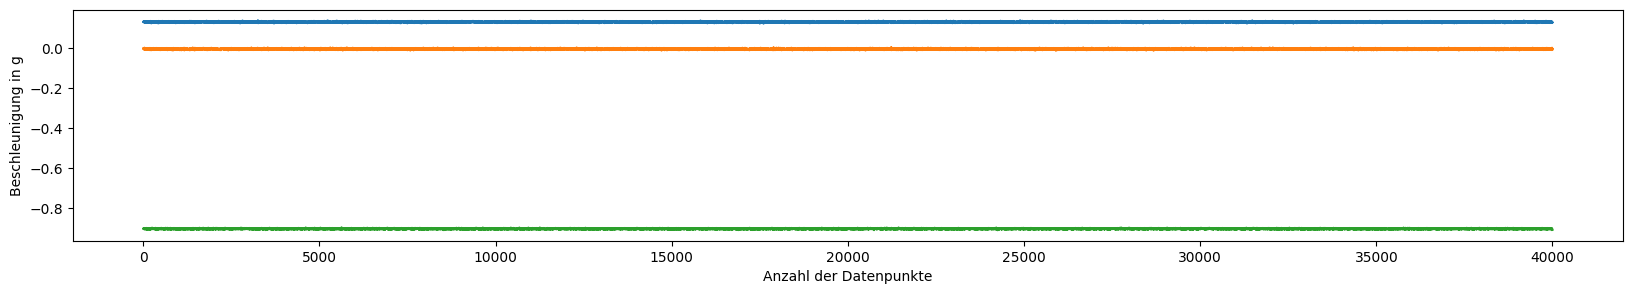

['largeloadcarriertrolley'] Anzahl Aufnahmen:  15


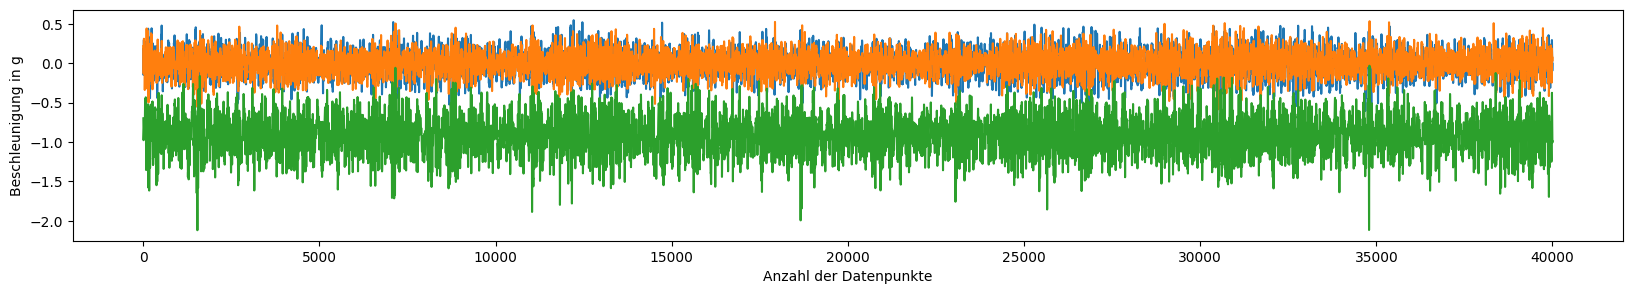

['liftingandlowering'] Anzahl Aufnahmen:  15


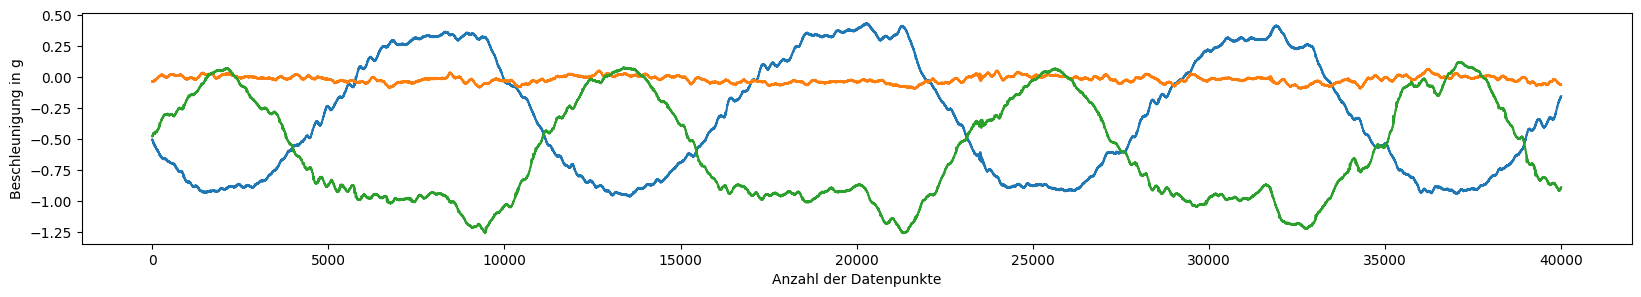

['movingtable'] Anzahl Aufnahmen:  15


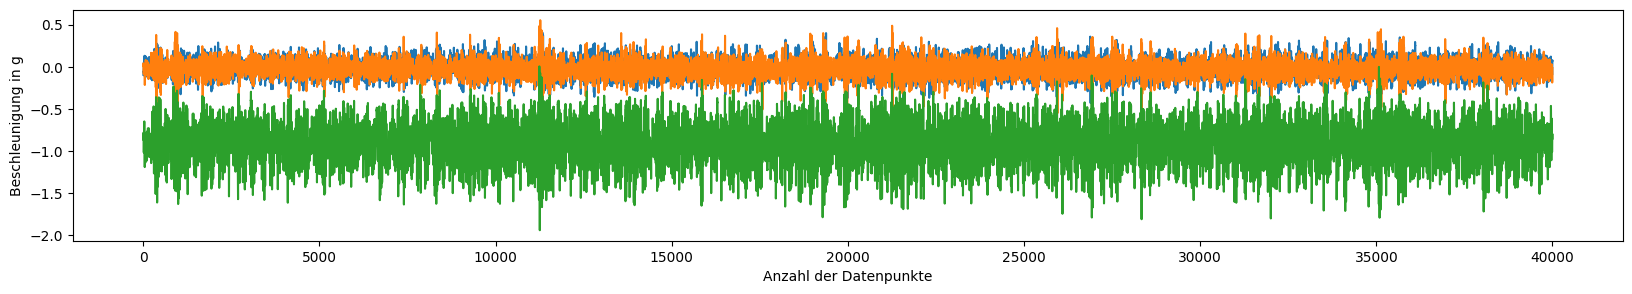

['palletjack'] Anzahl Aufnahmen:  15


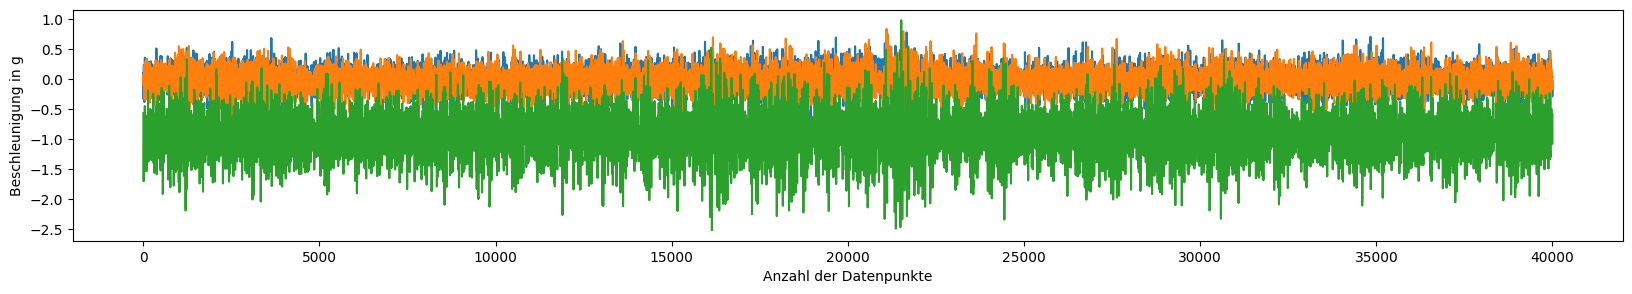

['rollerconveyor'] Anzahl Aufnahmen:  15


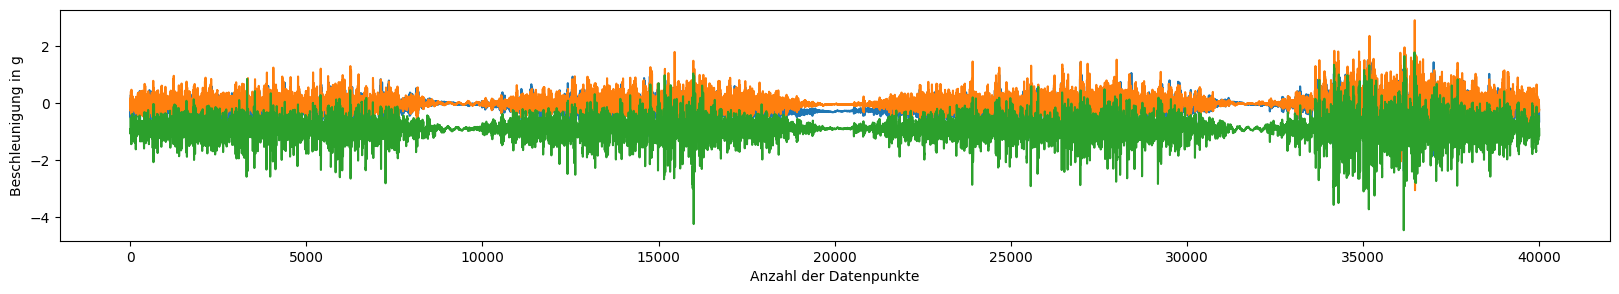

['rotatehorizontally'] Anzahl Aufnahmen:  15


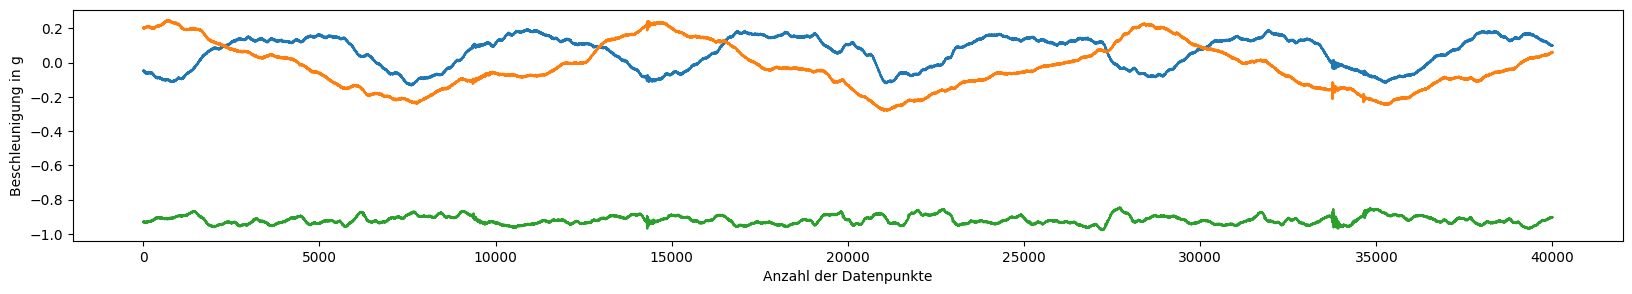

['sacktrolley'] Anzahl Aufnahmen:  15


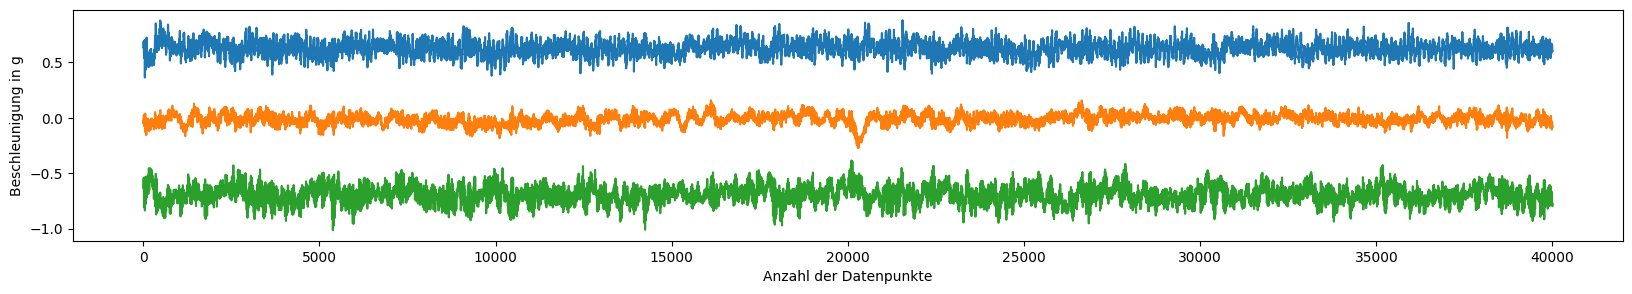

['walking'] Anzahl Aufnahmen:  15


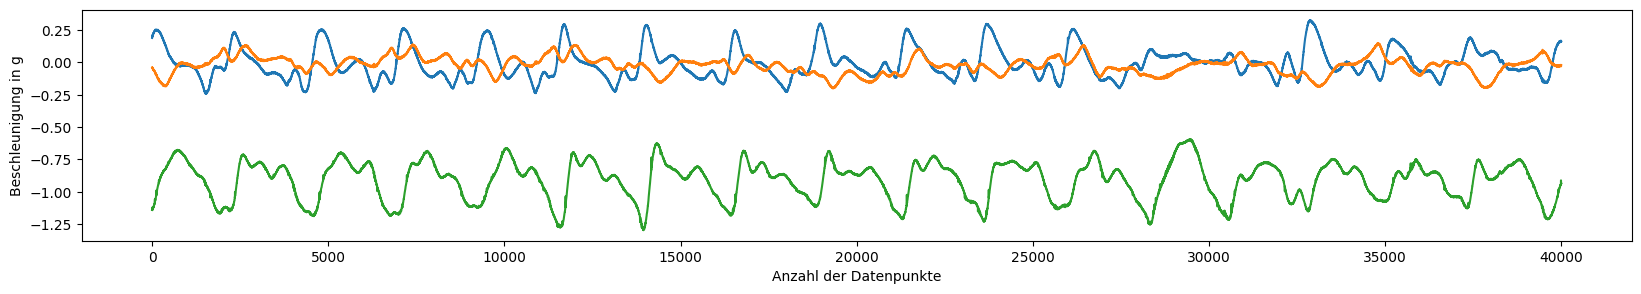

In [12]:
plotRandomDatapointsOfEachLabel(data, labels,type="line")

In [13]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features(accel_data):
    # Initialize the result array with zeros
    num_recordings = accel_data.shape[0]
    num_axes = 3
    num_features = 20
    features = np.zeros((num_recordings, num_axes, num_features))

    # Calculate the features for each axis and recording separately
    for recording in range(num_recordings):
        recording_data = accel_data[recording]

        for axis in range(num_axes):
            axis_data = recording_data[:, axis]

            max_value = np.max(axis_data)
            min_value = np.min(axis_data)
            abs_max_value = np.max(np.abs(axis_data))
            abs_min_value = np.min(np.abs(axis_data))
            mean_value = np.mean(axis_data)
            abs_energy_value = np.sum(np.square(axis_data))
            mean_abs_change_value = np.mean(np.abs(np.diff(axis_data)))
            cid_ce_value = np.sum(np.abs(np.diff(axis_data))) / (np.sum(np.abs(axis_data)) + 1e-9)
            std_value = np.std(axis_data)
            var_value = np.var(axis_data)
            count_above_mean_value = np.sum(axis_data > mean_value)
            count_below_mean_value = np.sum(axis_data < mean_value)
            first_position_of_max_value = np.argmax(axis_data)
            first_position_of_min_value = np.argmin(axis_data)
            max_count_value = np.sum(axis_data == max_value)
            min_count_value = np.sum(axis_data == min_value)
            has_large_std_value = int(std_value > np.percentile(axis_data, 95))
            skew_value = skew(axis_data)
            kurtosis_value = kurtosis(axis_data)
            variation_coefficient_value = np.std(axis_data) / np.mean(axis_data)

            # Add the features to the result array
            features[recording, axis] = np.array([
                max_value, min_value, abs_max_value, abs_min_value, mean_value,
                abs_energy_value, mean_abs_change_value, cid_ce_value, std_value,
                var_value, count_above_mean_value, count_below_mean_value,
                first_position_of_max_value, first_position_of_min_value,
                max_count_value, min_count_value, has_large_std_value, skew_value,
                kurtosis_value, variation_coefficient_value
            ])

    # Combine the features for all three axes
    features = features.reshape(num_recordings, -1)

    # Return the features as a NumPy array
    return features

In [14]:
data = extract_features(data)

In [15]:
data.shape

(135, 60)

In [16]:
import pandas as pd
dataDF = pd.DataFrame(data)

In [17]:
dataDF

0         1         2             3         4             5   \
0    0.211624 -0.923723  0.923723  9.623892e-06 -0.357776  10664.378844   
1    0.682524 -0.887285  0.887285  4.372811e-06 -0.004763   1109.101981   
2    0.159592 -0.235930  0.235930  3.271091e-07 -0.012418    321.994422   
3    0.211359 -0.165445  0.211359  1.008375e-06  0.059446    523.492689   
4    0.260323 -0.986933  0.986933  1.090833e-06 -0.333783  10716.107749   
..        ...       ...       ...           ...       ...           ...   
130  0.967566 -0.767675  0.967566  9.426638e-06 -0.004026   1229.911957   
131  0.290527 -0.913567  0.913567  1.624049e-05 -0.300255  10166.083825   
132  1.700769 -1.876928  1.876928  4.780797e-06 -0.146602   3066.431153   
133  0.862944  0.368010  0.862944  3.680104e-01  0.608455  14962.106571   
134  0.907978  0.363954  0.907978  3.639538e-01  0.607677  14937.619486   

           6         7         8         9   ...       50       51       52  \
0    0.001370  0.003373  0.372298  0.138606  ...  17725.0  22275.0  11931.0   
1    0.041251  0.312839  0.166448  0.027705  ...  20349.0  19651.0  26456.0   
2    0.001515  0.020053  0.088858  0.007896  ...  19523.0  20477.0   9325.0   
3    0.001374  0.013342  0.097742  0.009553  ...  21970.0  18030.0  16043.0   
4    0.001299  0.003199  0.395590  0.156492  ...  17300.0  22700.0  18219.0   
..        ...       ...       ...       ...  ...      ...      ...      ...   
130  0.043735  0.313153  0.175304  0.030732  ...  20365.0  19635.0  13155.0   
131  0.001298  0.003236  0.404968  0.163999  ...  15885.0  24115.0   9655.0   
132  0.057365  0.270455  0.234880  0.055169  ...  20488.0  19512.0  35526.0   
133  0.009377  0.015411  0.061929  0.003835  ...  20032.0  19968.0  33988.0   
134  0.009103  0.014980  0.064572  0.004170  ...  19621.0  20379.0  33918.0   

          53   54   55   56        57        58        59  
0     7345.0  1.0  1.0  1.0  0.442738 -1.229447 -0.542301  
1    35344.0  1.0  1.0  1.0 -0.191851  0.117247 -0.396099  
2     7082.0  1.0  1.0  1.0 -0.079174  0.692572 -0.032061  
3    20118.0  1.0  1.0  1.0 -0.443230  0.117048 -0.026712  
4    35015.0  1.0  1.0  1.0  0.438713 -1.311162 -0.652264  
..       ...  ...  ...  ...       ...       ...       ...  
130  13123.0  1.0  1.0  1.0 -0.170048  0.178956 -0.412674  
131   4931.0  1.0  1.0  1.0  0.705548 -0.955518 -0.547096  
132  10107.0  1.0  1.0  1.0 -0.300248  2.908651 -0.340552  
133  18986.0  1.0  1.0  1.0  0.021033 -0.028566 -0.102947  
134  26947.0  1.0  1.0  1.0  0.142247  0.152618 -0.105405  

[135 rows x 60 columns]

In [18]:
ypred = loaded_model.predict(dataDF)

In [19]:
ypred = np.array([str(item) for item in ypred])  # Convert elements to strings
ypred = np.char.lower(np.char.replace(ypred, ' ', ''))

In [20]:
ypred.shape

(135,)

In [21]:
np.unique(ypred)

array(['idle', 'largeloadcarriertrolley', 'liftingandlowering',
       'movingtable', 'palletjack', 'rollerconveyor',
       'rotatehorizontally', 'sacktrolley', 'walking'], dtype='<U23')

In [22]:
labels.shape

(135, 1)

In [23]:
labels = labels.reshape(135)

In [24]:

# Assuming you have the NumPy arrays ypred and labels with shape (135,)
input = {'predicted': ypred, 'actual': labels}
df = pd.DataFrame(input)

# Printing the DataFrame
print(df)


              predicted              actual
0    liftingandlowering  liftingandlowering
1            palletjack          palletjack
2    rotatehorizontally  rotatehorizontally
3    rotatehorizontally  rotatehorizontally
4    liftingandlowering  liftingandlowering
..                  ...                 ...
130          palletjack          palletjack
131  liftingandlowering  liftingandlowering
132      rollerconveyor      rollerconveyor
133         sacktrolley         sacktrolley
134         sacktrolley         sacktrolley

[135 rows x 2 columns]


In [25]:
df["error"] = df.apply(lambda row: 1 if row["predicted"] != row["actual"] else 0, axis=1)

In [26]:
df["error"].values.shape

(135,)

In [27]:
indicesOfErrors = []
for idx,error in enumerate(df["error"].values):
    if error:
        indicesOfErrors.append(idx)
print(indicesOfErrors)

[7, 12, 14, 17, 18, 20, 24, 25, 44, 52, 72, 75, 81, 83, 90, 106, 112, 122, 126]


index:  7 label:  largeloadcarriertrolley


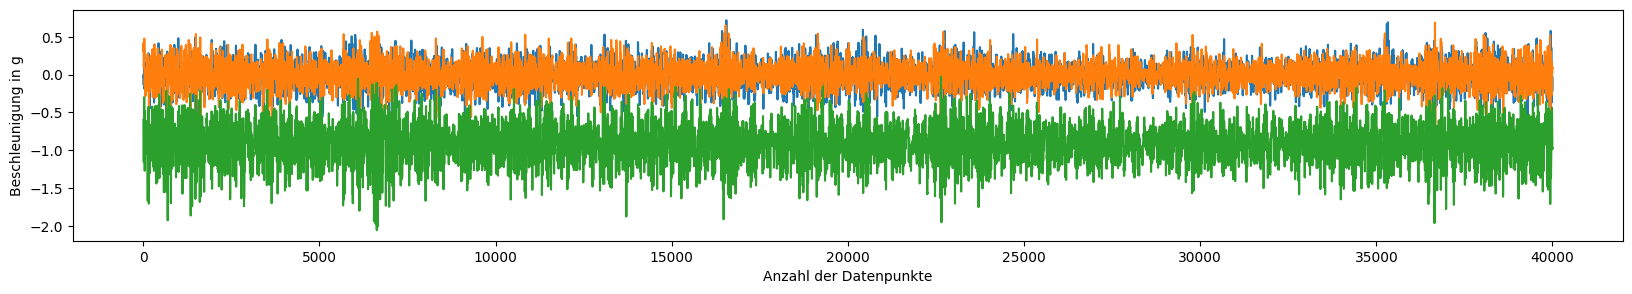

index:  12 label:  palletjack


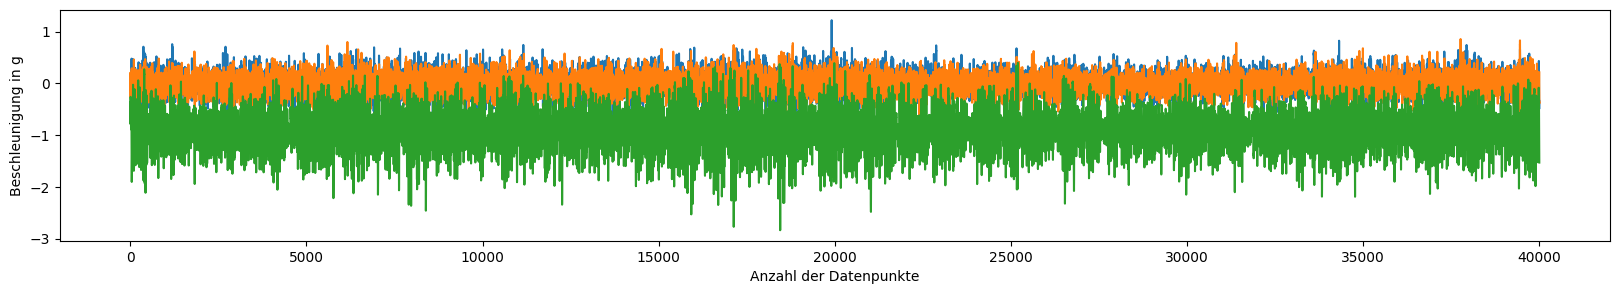

index:  14 label:  largeloadcarriertrolley


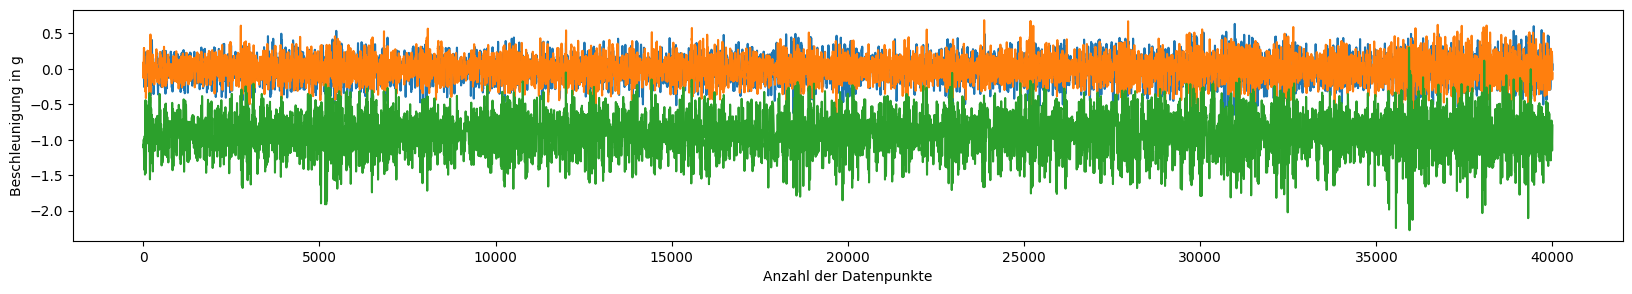

index:  17 label:  largeloadcarriertrolley


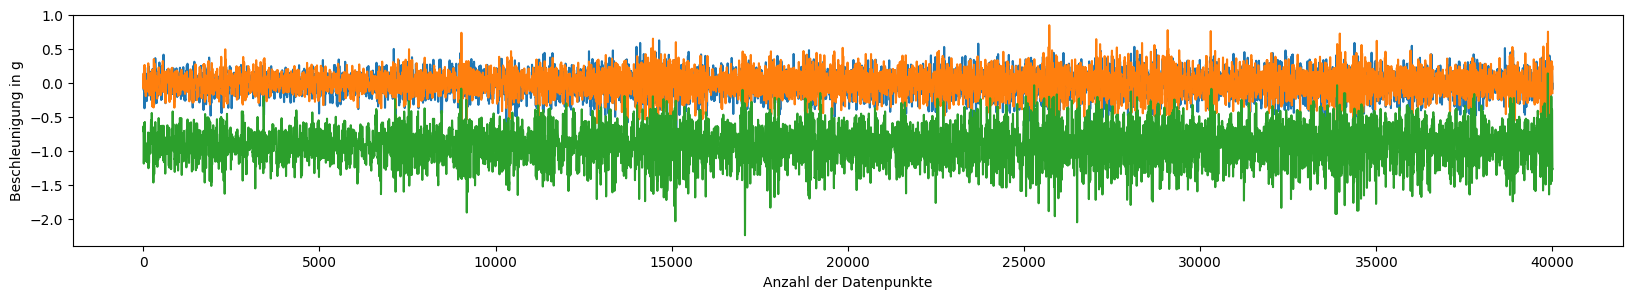

index:  18 label:  largeloadcarriertrolley


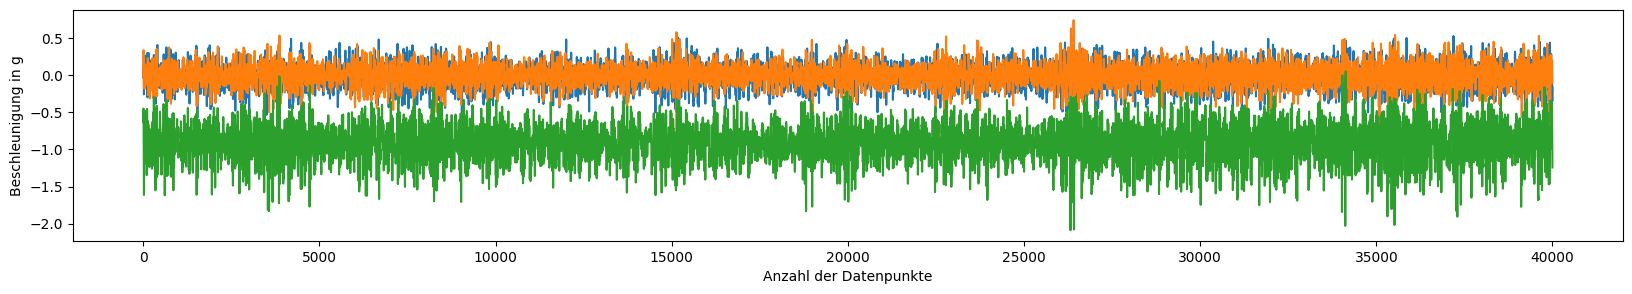

index:  20 label:  largeloadcarriertrolley


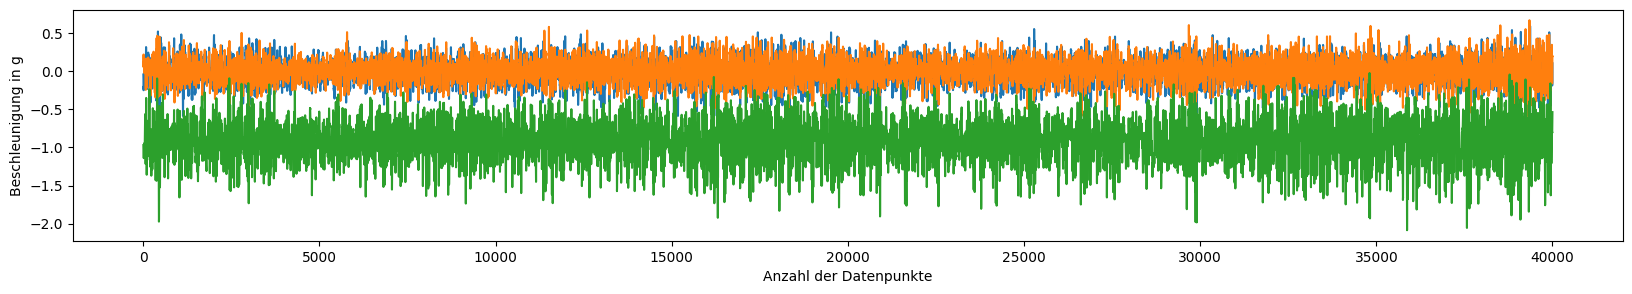

index:  24 label:  largeloadcarriertrolley


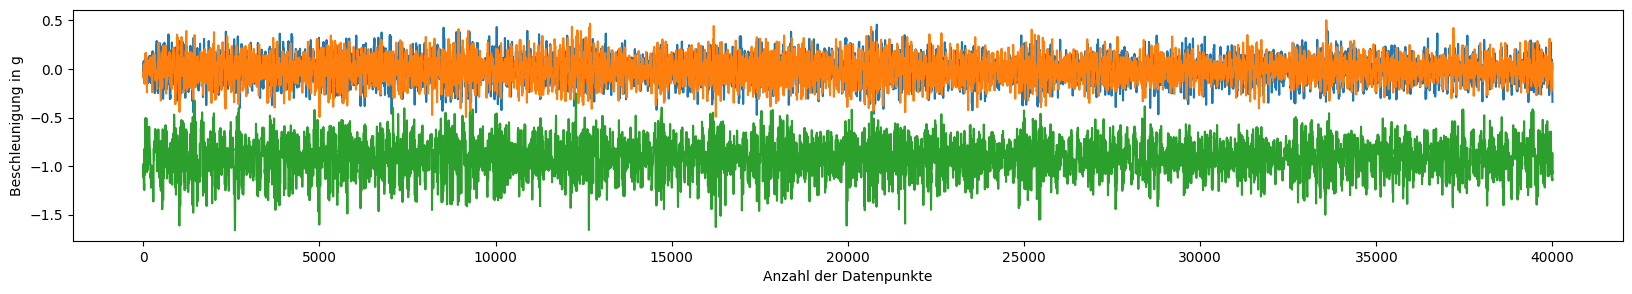

index:  25 label:  largeloadcarriertrolley


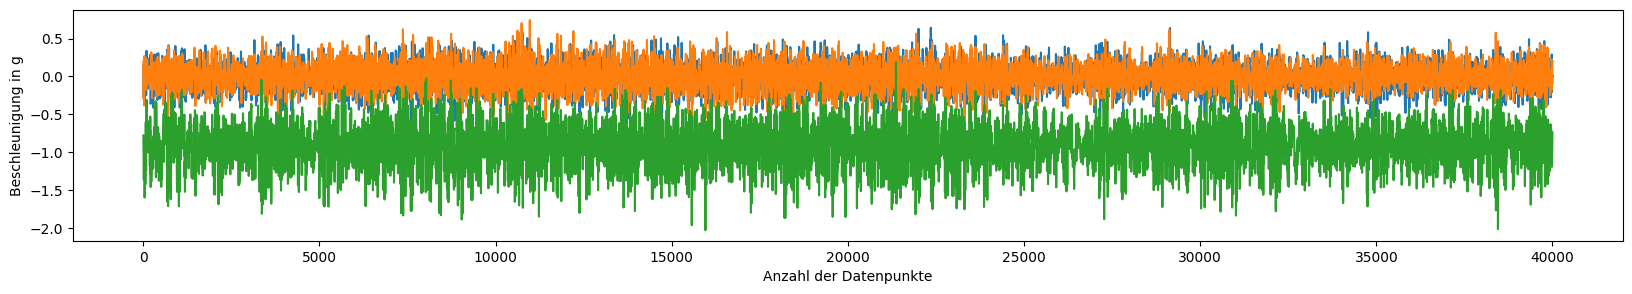

index:  44 label:  palletjack


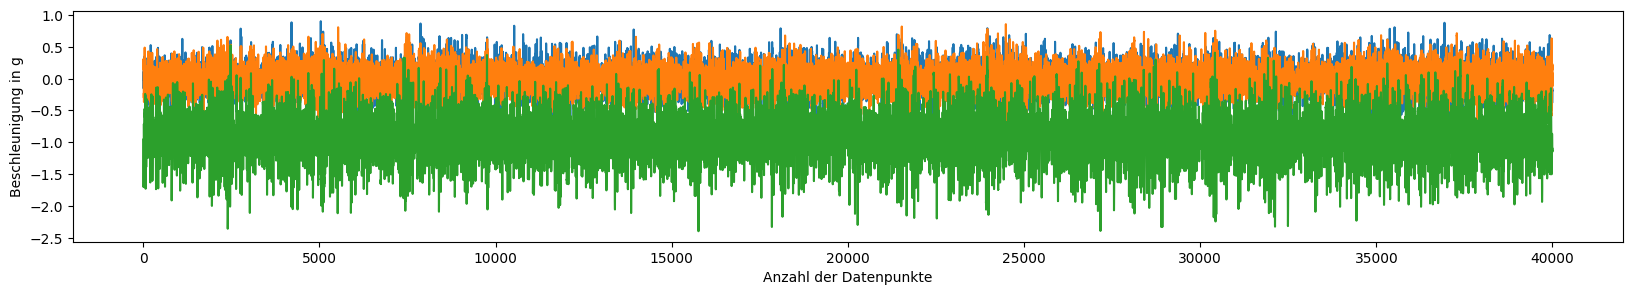

index:  52 label:  palletjack


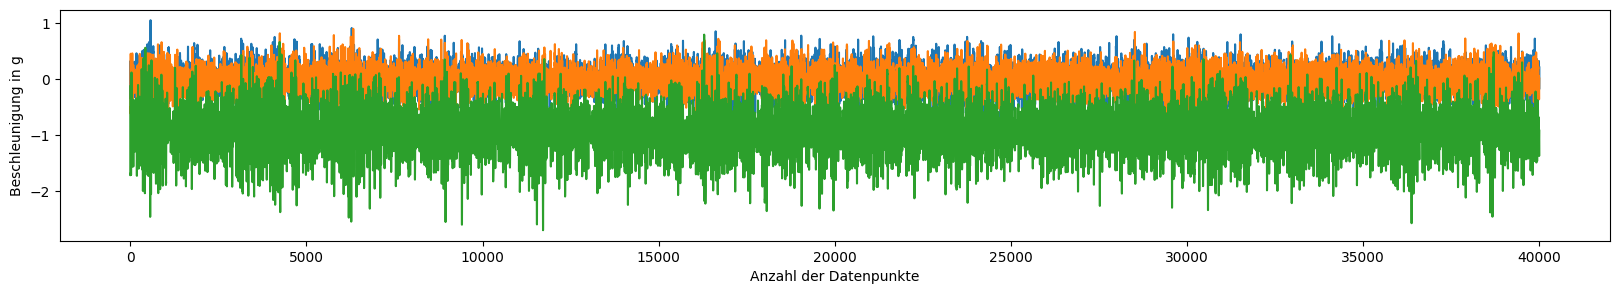

index:  72 label:  largeloadcarriertrolley


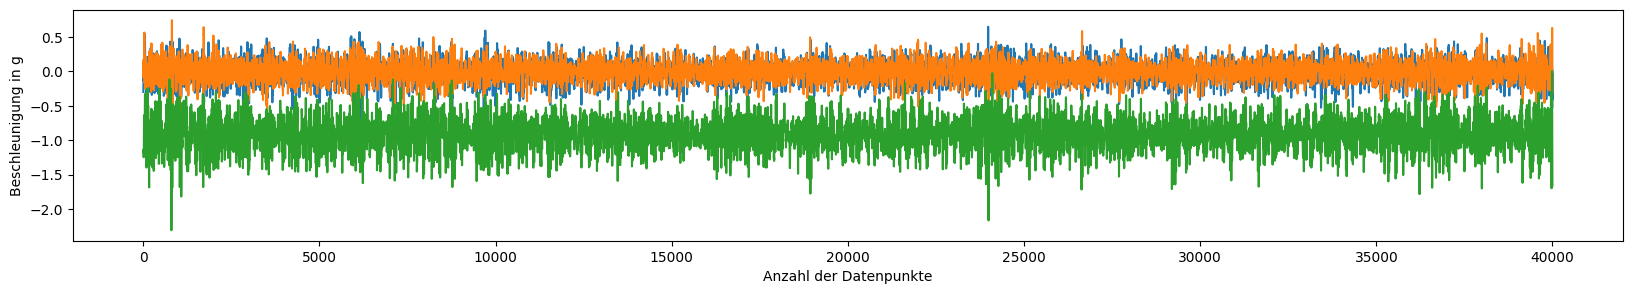

index:  75 label:  largeloadcarriertrolley


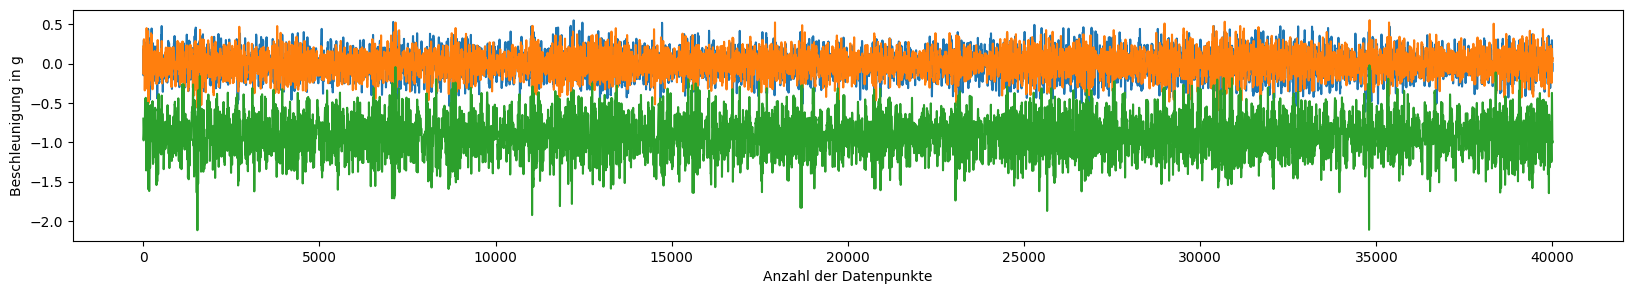

index:  81 label:  largeloadcarriertrolley


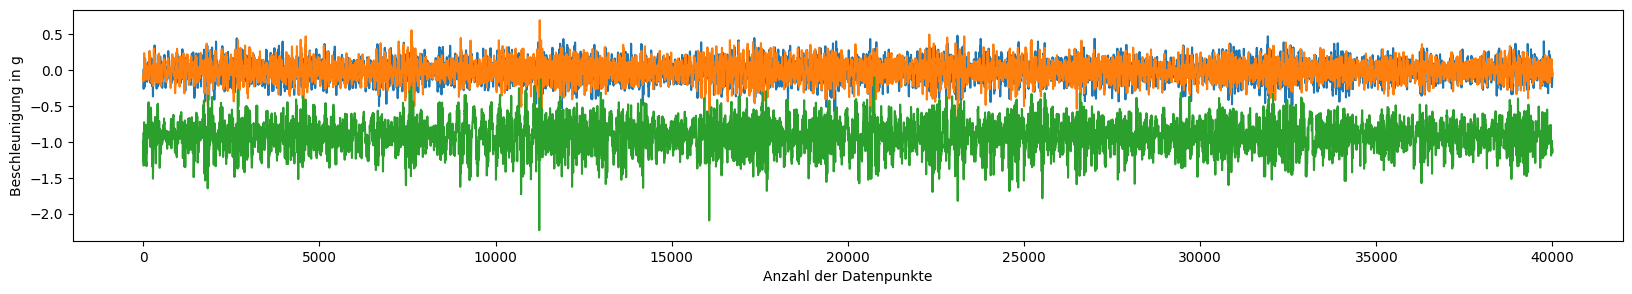

index:  83 label:  largeloadcarriertrolley


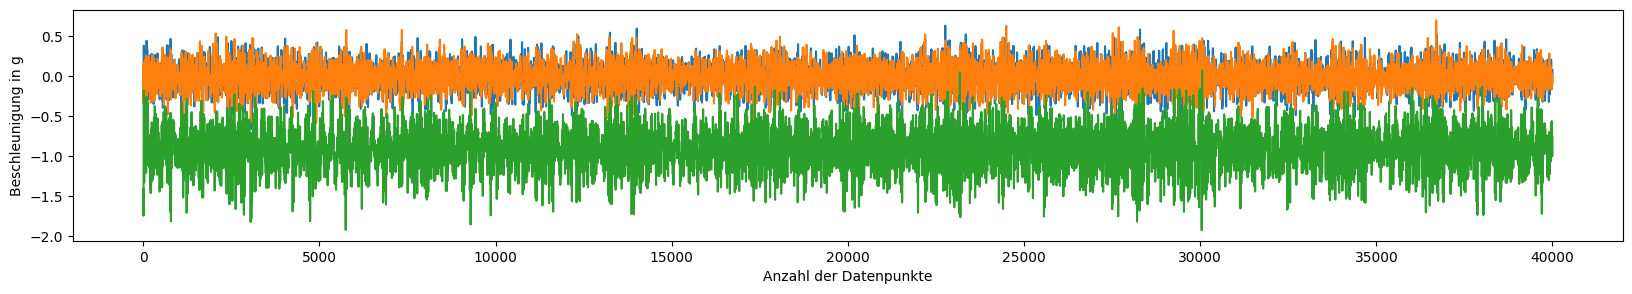

index:  90 label:  largeloadcarriertrolley


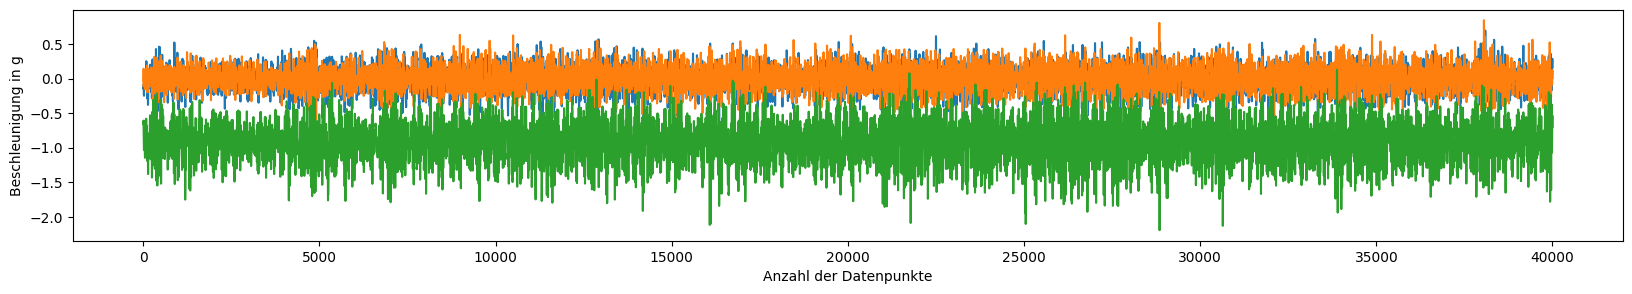

index:  106 label:  largeloadcarriertrolley


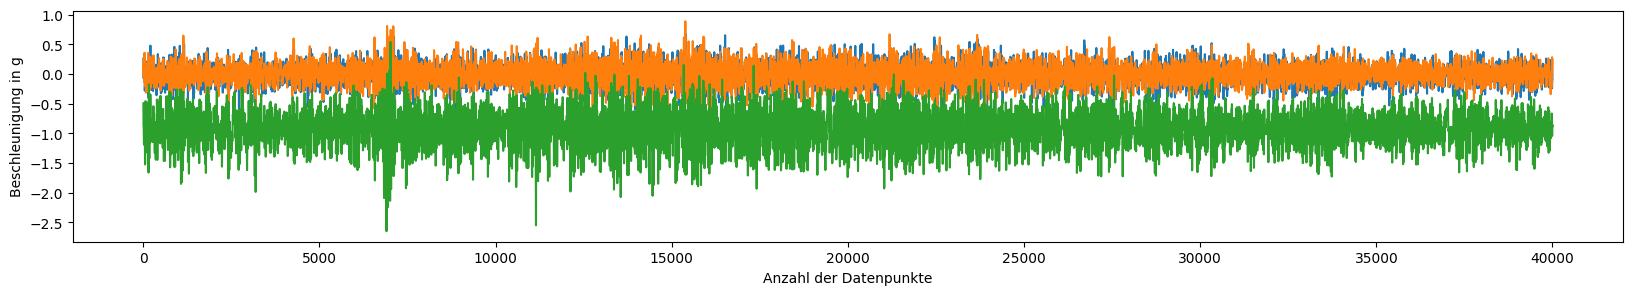

index:  112 label:  largeloadcarriertrolley


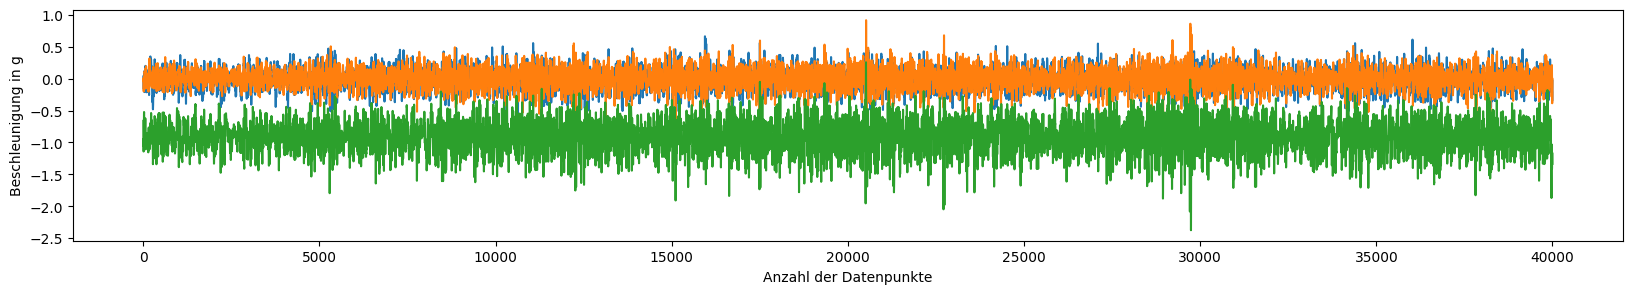

index:  122 label:  largeloadcarriertrolley


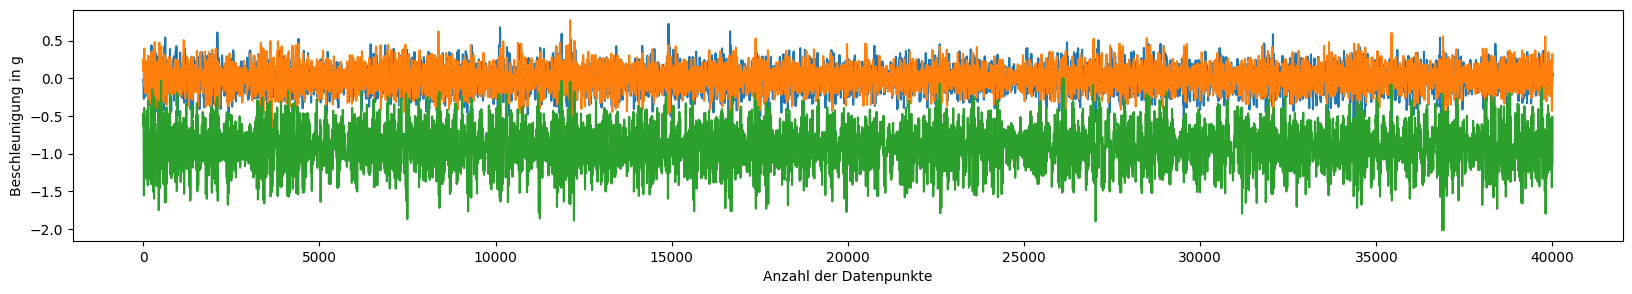

index:  126 label:  liftingandlowering


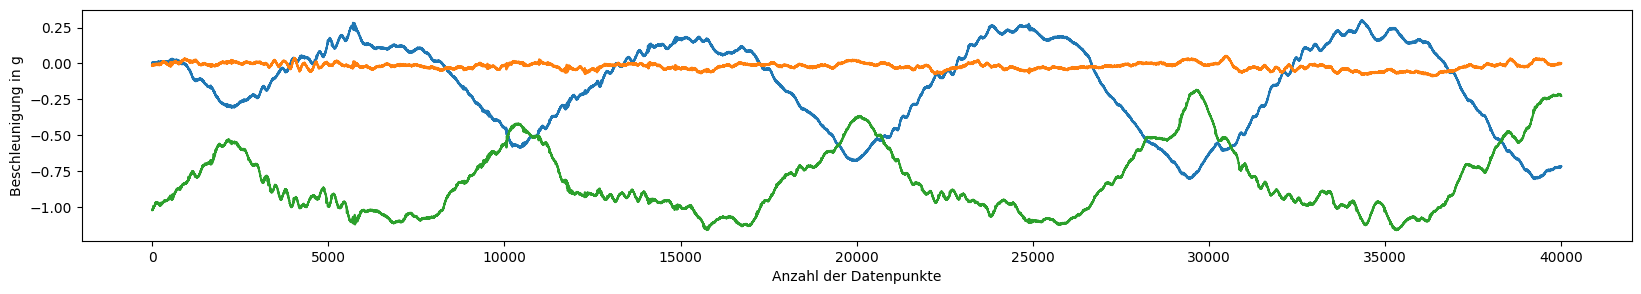

In [28]:
plotDatapointsViaIndicesOfLabel(acceleration_array, labels, indicesOfErrors)

In [29]:
# Assuming you have the DataFrame named 'df' with columns 'predicted' and 'actual'

# Create a crosstab of 'predicted' and 'actual' columns
confusion_matrix = pd.crosstab(df['predicted'], df['actual'])

# Printing the confusion matrix
print(confusion_matrix)

actual                   idle  largeloadcarriertrolley  liftingandlowering  \
predicted                                                                    
idle                       15                        0                   0   
largeloadcarriertrolley     0                        0                   0   
liftingandlowering          0                        0                  14   
movingtable                 0                        4                   0   
palletjack                  0                       11                   0   
rollerconveyor              0                        0                   0   
rotatehorizontally          0                        0                   0   
sacktrolley                 0                        0                   0   
walking                     0                        0                   1   

actual                   movingtable  palletjack  rollerconveyor  \
predicted                                                          
idle 

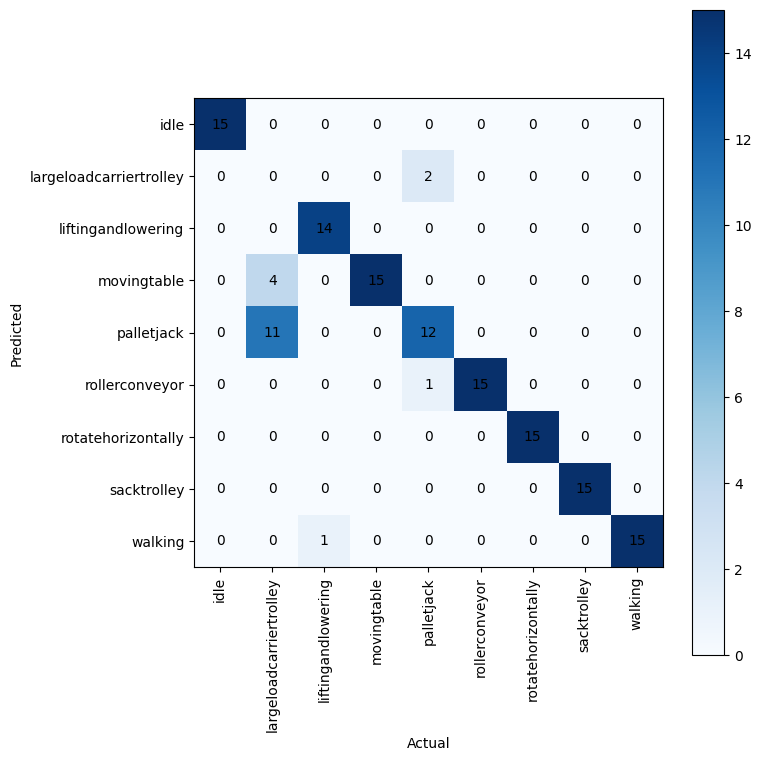

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have the confusion matrix stored in the variable 'confusion_matrix'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(confusion_matrix.shape[1]))
ax.set_yticks(np.arange(confusion_matrix.shape[0]))
ax.set_xticklabels(confusion_matrix.columns, rotation=90)
ax.set_yticklabels(confusion_matrix.index)

# Add values to the plot
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        text = ax.text(j, i, confusion_matrix.iloc[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


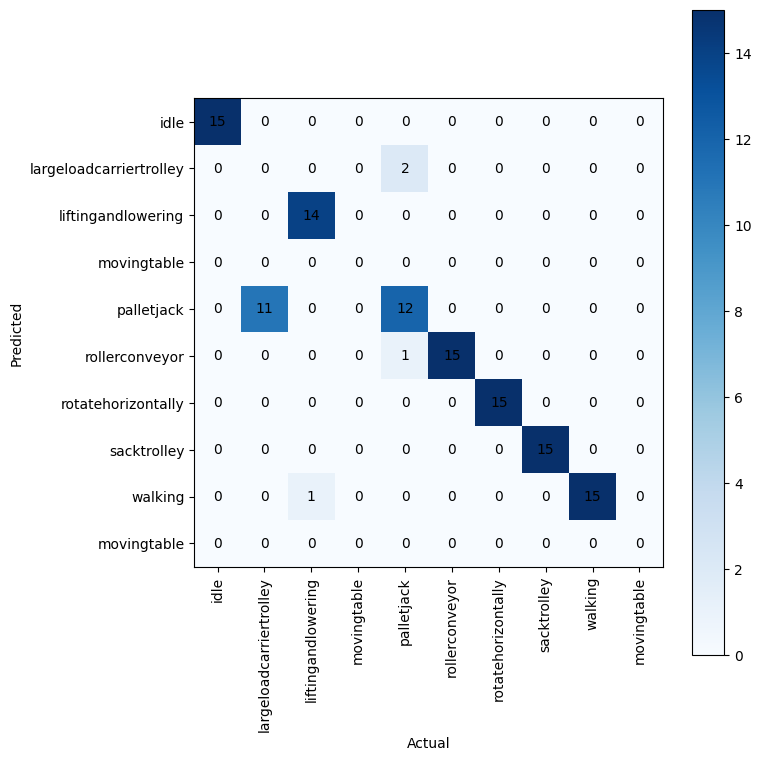

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you have the confusion matrix stored in the variable 'confusion_matrix'

# Add an additional row and column for the "movingtable" label
confusion_matrix = confusion_matrix.reindex(index=confusion_matrix.index.append(pd.Index(["movingtable"])),
                                             columns=confusion_matrix.columns.append(pd.Index(["movingtable"])))
confusion_matrix.loc["movingtable", :] = 0
confusion_matrix.loc[:, "movingtable"] = 0

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(confusion_matrix, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(confusion_matrix.shape[1]))
ax.set_yticks(np.arange(confusion_matrix.shape[0]))
ax.set_xticklabels(confusion_matrix.columns, rotation=90)
ax.set_yticklabels(confusion_matrix.index)

# Add values to the plot
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        text = ax.text(j, i, confusion_matrix.iloc[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix

# Assuming you have the NumPy arrays 'ypred' and 'labels'

# Create the confusion matrix
cm = confusion_matrix(labels, ypred)

# Printing the confusion matrix
print(cm)


[[15  0  0  0  0  0  0  0  0]
 [ 0  0  0  4 11  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  1]
 [ 0  0  0 15  0  0  0  0  0]
 [ 0  2  0  0 12  1  0  0  0]
 [ 0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  0 15]]


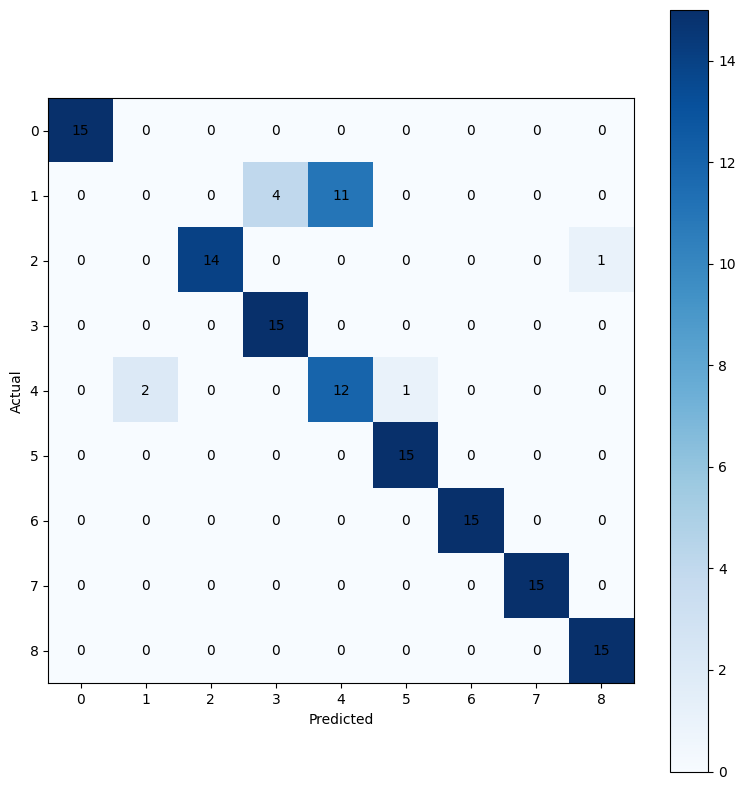

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have the confusion matrix stored in the variable 'cm'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

# Add values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


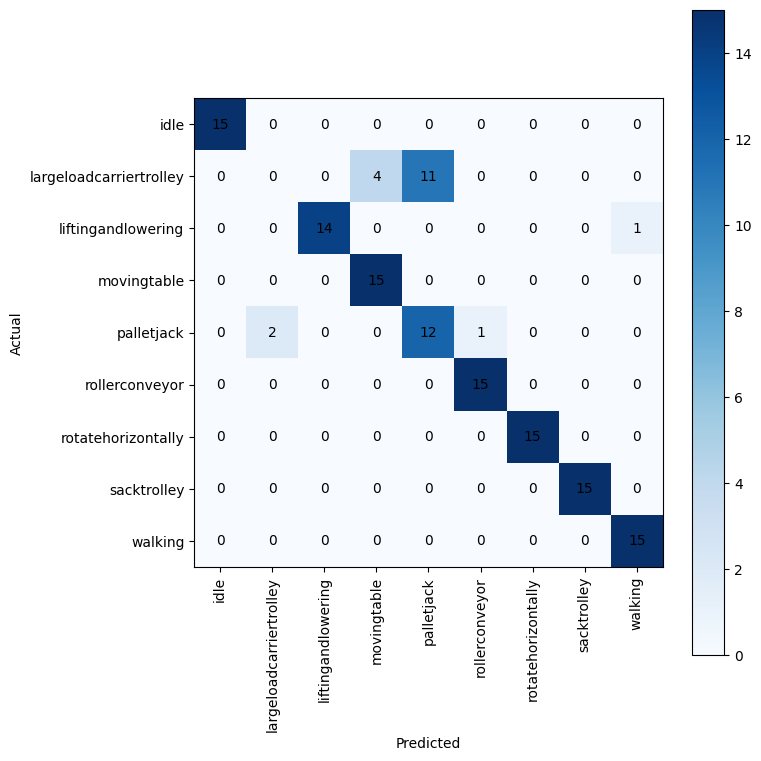

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have the confusion matrix stored in the variable 'cm'
# Assuming you have the 'labels' array with unique class labels

# Get the unique class labels from the confusion matrix
unique_labels = np.unique(labels)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confusion matrix
im = ax.imshow(cm, cmap='Blues')

# Set axis labels
ax.set_xticks(np.arange(len(unique_labels)))
ax.set_yticks(np.arange(len(unique_labels)))
ax.set_xticklabels(unique_labels, rotation=90)
ax.set_yticklabels(unique_labels)

# Add values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text = ax.text(j, i, cm[i, j],
                       ha='center', va='center', color='black')

# Set axis titles
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Set colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show plot
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import f1_score

# Assuming you have the true labels in the 'labels' array and the predicted labels in the 'ypred' array

# Calculate the F1-score
f1 = f1_score(labels, ypred, average='weighted')

# Print the F1-score
print("F1-score:", f1)


F1-score: 0.8238814445435494
